### Supermarket Simulation Using Markov Chains

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt

### 1. EDA

In [2]:
df = pd.read_csv('_RES/monday.csv', sep=';')

In [3]:
df.shape

(4884, 3)

In [4]:
df.head()

,timestamp,customer_no,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,3,dairy
3,2019-09-02 07:04:00,4,dairy
4,2019-09-02 07:04:00,5,spices


In [5]:
df.tail()

,timestamp,customer_no,location
4879,2019-09-02 21:49:00,1442,checkout
4880,2019-09-02 21:49:00,1444,checkout
4881,2019-09-02 21:49:00,1445,dairy
4882,2019-09-02 21:50:00,1446,dairy
4883,2019-09-02 21:50:00,1447,fruit


In [6]:
df.describe()

,customer_no
count,4884.000000
mean,718.274365
std,411.839636
min,1.000000
25%,366.000000
50%,720.000000
75%,1070.000000
max,1447.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4884 entries, 0 to 4883
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   timestamp    4884 non-null   object
 1   customer_no  4884 non-null   int64 
 2   location     4884 non-null   object
dtypes: int64(1), object(2)
memory usage: 114.6+ KB


#### Create datetime index

In [8]:
datetime = pd.to_datetime(df['timestamp'])
df.index = pd.DatetimeIndex(datetime)
df = df.drop(['timestamp'], axis=1)

In [9]:
df.head()

,customer_no,location
timestamp,,
2019-09-02 07:03:00,1,dairy
2019-09-02 07:03:00,2,dairy
2019-09-02 07:04:00,3,dairy
2019-09-02 07:04:00,4,dairy
2019-09-02 07:04:00,5,spices


#### Calculate the total number of customers in each section

In [10]:
df.groupby(by=['location']).nunique()

,customer_no,location
location,,
checkout,1437,1
dairy,720,1
drinks,661,1
fruit,827,1
spices,584,1


#### Calculate the total number of customers in each section over time

Showing how many customers are present on how many locations over time

In [11]:
df.groupby(by=['timestamp']).nunique()

,customer_no,location
timestamp,,
2019-09-02 07:03:00,2,1
2019-09-02 07:04:00,6,3
2019-09-02 07:05:00,4,3
2019-09-02 07:06:00,8,5
2019-09-02 07:07:00,4,4
...,...,...
2019-09-02 21:46:00,6,4
2019-09-02 21:47:00,6,3
2019-09-02 21:48:00,7,4


Showing how many customers are present at individual locations over time

In [12]:
df.groupby(['timestamp', 'location']).count().unstack(level=1)

customer_no                          
location               checkout dairy drinks fruit spices
timestamp                                                
2019-09-02 07:03:00         NaN   2.0    NaN   NaN    NaN
2019-09-02 07:04:00         NaN   2.0    NaN   1.0    3.0
2019-09-02 07:05:00         2.0   1.0    1.0   NaN    NaN
2019-09-02 07:06:00         2.0   2.0    1.0   2.0    1.0
2019-09-02 07:07:00         1.0   1.0    1.0   NaN    1.0
...                         ...   ...    ...   ...    ...
2019-09-02 21:46:00         1.0   NaN    2.0   1.0    2.0
2019-09-02 21:47:00         2.0   2.0    NaN   2.0    NaN
2019-09-02 21:48:00         2.0   2.0    2.0   NaN    1.0
2019-09-02 21:49:00         2.0   1.0    NaN   2.0    2.0
2019-09-02 21:50:00         NaN   1.0    NaN   1.0    NaN

[874 rows x 5 columns]

Showing grouped information on location over time for individual customers

In [13]:
df.groupby(['customer_no', 'timestamp']).sum()

location
customer_no timestamp                    
1           2019-09-02 07:03:00     dairy
            2019-09-02 07:05:00  checkout
2           2019-09-02 07:03:00     dairy
            2019-09-02 07:06:00  checkout
3           2019-09-02 07:04:00     dairy
...                                   ...
1444        2019-09-02 21:48:00    spices
            2019-09-02 21:49:00  checkout
1445        2019-09-02 21:49:00     dairy
1446        2019-09-02 21:50:00     dairy
1447        2019-09-02 21:50:00     fruit

[4884 rows x 1 columns]

#### Upsampling Customers
There are missing values for some customers at specific times, which can be forward filled (assuming they've always just stayed at the previous location)

Let's start with customer 7.

In [14]:
df[df['customer_no'] == 7]

,customer_no,location
timestamp,,
2019-09-02 07:04:00,7,spices
2019-09-02 07:05:00,7,drinks
2019-09-02 07:09:00,7,spices
2019-09-02 07:11:00,7,fruit
2019-09-02 07:13:00,7,checkout


In [15]:
df[df['customer_no'] == 7].resample('T').ffill()

,customer_no,location
timestamp,,
2019-09-02 07:04:00,7,spices
2019-09-02 07:05:00,7,drinks
2019-09-02 07:06:00,7,drinks
2019-09-02 07:07:00,7,drinks
2019-09-02 07:08:00,7,drinks
2019-09-02 07:09:00,7,spices
2019-09-02 07:10:00,7,spices
2019-09-02 07:11:00,7,fruit
2019-09-02 07:12:00,7,fruit


Of course, if we now want to do this for all customers at the same time using 'unstack' this gets problematic, because most of the timestamps already exist for one customer or the other.

So, either we deal with this by forward filling the missing values (giving us loads of 'checkouts') or we use a for-loop to go through each customer.

In [16]:
df2 = df.groupby(['timestamp', 'customer_no']).sum().unstack(level=1).resample('T').ffill().fillna(method='ffill')
df2

location                                          \
customer_no              1         2         3         4         5      
timestamp                                                               
2019-09-02 07:03:00     dairy     dairy       NaN       NaN       NaN   
2019-09-02 07:04:00     dairy     dairy     dairy     dairy    spices   
2019-09-02 07:05:00  checkout     dairy     dairy     dairy  checkout   
2019-09-02 07:06:00  checkout  checkout  checkout     dairy  checkout   
2019-09-02 07:07:00  checkout  checkout  checkout     dairy  checkout   
...                       ...       ...       ...       ...       ...   
2019-09-02 21:46:00  checkout  checkout  checkout  checkout  checkout   
2019-09-02 21:47:00  checkout  checkout  checkout  checkout  checkout   
2019-09-02 21:48:00  checkout  checkout  checkout  checkout  checkout   
2019-09-02 21:49:00  checkout  checkout  checkout  checkout  checkout   
2019-09-02 21:50:00  checkout  checkout  checkout  checkout  checkout   

                                                                       ...  \
customer_no              6         7         8         9         10    ...   
timestamp                                                              ...   
2019-09-02 07:03:00       NaN       NaN       NaN       NaN       NaN  ...   
2019-09-02 07:04:00    spices    spices     fruit       NaN       NaN  ...   
2019-09-02 07:05:00     dairy    drinks     fruit       NaN       NaN  ...   
2019-09-02 07:06:00     dairy    drinks     fruit     dairy     fruit  ...   
2019-09-02 07:07:00     dairy    drinks  checkout     dairy     fruit  ...   
...                       ...       ...       ...       ...       ...  ...   
2019-09-02 21:46:00  checkout  checkout  checkout  checkout  checkout  ...   
2019-09-02 21:47:00  checkout  checkout  checkout  checkout  checkout  ...   
2019-09-02 21:48:00  checkout  checkout  checkout  checkout  checkout  ...   
2019-09-02 21:49:00  checkout  checkout  checkout  checkout  checkout  ...   
2019-09-02 21:50:00  checkout  checkout  checkout  checkout  checkout  ...   

                                                                       \
customer_no              1438   1439    1440    1441      1442   1443   
timestamp                                                               
2019-09-02 07:03:00       NaN    NaN     NaN     NaN       NaN    NaN   
2019-09-02 07:04:00       NaN    NaN     NaN     NaN       NaN    NaN   
2019-09-02 07:05:00       NaN    NaN     NaN     NaN       NaN    NaN   
2019-09-02 07:06:00       NaN    NaN     NaN     NaN       NaN    NaN   
2019-09-02 07:07:00       NaN    NaN     NaN     NaN       NaN    NaN   
...                       ...    ...     ...     ...       ...    ...   
2019-09-02 21:46:00    spices  fruit  drinks     NaN       NaN    NaN   
2019-09-02 21:47:00  checkout  fruit  drinks   dairy     fruit  fruit   
2019-09-02 21:48:00  checkout  fruit  drinks  drinks     fruit  dairy   
2019-09-02 21:49:00  checkout  fruit  spices  spices  checkout  dairy   
2019-09-02 21:50:00  checkout  fruit  spices  spices  checkout  dairy   

                                                    
customer_no              1444   1445   1446   1447  
timestamp                                           
2019-09-02 07:03:00       NaN    NaN    NaN    NaN  
2019-09-02 07:04:00       NaN    NaN    NaN    NaN  
2019-09-02 07:05:00       NaN    NaN    NaN    NaN  
2019-09-02 07:06:00       NaN    NaN    NaN    NaN  
2019-09-02 07:07:00       NaN    NaN    NaN    NaN  
...                       ...    ...    ...    ...  
2019-09-02 21:46:00       NaN    NaN    NaN    NaN  
2019-09-02 21:47:00       NaN    NaN    NaN    NaN  
2019-09-02 21:48:00    spices    NaN    NaN    NaN  
2019-09-02 21:49:00  checkout  dairy    NaN    NaN  
2019-09-02 21:50:00  checkout  dairy  dairy  fruit  

[888 rows x 1447 columns]

In [17]:
df2.stack(level=1).reset_index()

,timestamp,customer_no,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,1,dairy
3,2019-09-02 07:04:00,2,dairy
4,2019-09-02 07:04:00,3,dairy
...,...,...,...
625742,2019-09-02 21:50:00,1443,dairy
625743,2019-09-02 21:50:00,1444,checkout
625744,2019-09-02 21:50:00,1445,dairy
625745,2019-09-02 21:50:00,1446,dairy


#### The for-loop

How many customers are there to be upsampled?

In [18]:
customer_range = df['customer_no'].max() + 1

Create a new, empty DataFrame

In [19]:
df3 = pd.DataFrame(data=None, columns=df.columns)
df3

,customer_no,location


Loop through all customers, upsample datetime and location and append old and new values to the newly created DataFrame

In [20]:
for customer in range (1, customer_range):
    new_rows = df[df['customer_no'] == customer].resample('T').ffill().reset_index()
    df3 = df3.append(new_rows, ignore_index=True)

Recreate the datetime index

In [21]:
df3.index = pd.DatetimeIndex(df3['timestamp'])
df3 = df3.drop(['timestamp'], axis=1)

In [22]:
df3

,customer_no,location
timestamp,,
2019-09-02 07:03:00,1,dairy
2019-09-02 07:04:00,1,dairy
2019-09-02 07:05:00,1,checkout
2019-09-02 07:03:00,2,dairy
2019-09-02 07:04:00,2,dairy
...,...,...
2019-09-02 21:48:00,1444,spices
2019-09-02 21:49:00,1444,checkout
2019-09-02 21:49:00,1445,dairy


In [23]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10765 entries, 2019-09-02 07:03:00 to 2019-09-02 21:50:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_no  10765 non-null  object
 1   location     10765 non-null  object
dtypes: object(2)
memory usage: 252.3+ KB


In preparation for the plotting, downsample the data to display total hourly count

In [24]:
df3.groupby(['timestamp', 'location']).count().unstack(level=1).resample('H').count()

customer_no                          
location               checkout dairy drinks fruit spices
timestamp                                                
2019-09-02 07:00:00          50    57     53    54     37
2019-09-02 08:00:00          52    59     52    58     41
2019-09-02 09:00:00          43    59     57    58     42
2019-09-02 10:00:00          46    59     49    57     41
2019-09-02 11:00:00          36    56     38    48     33
2019-09-02 12:00:00          44    57     52    54     45
2019-09-02 13:00:00          54    60     57    58     50
2019-09-02 14:00:00          46    59     44    56     43
2019-09-02 15:00:00          47    60     51    55     47
2019-09-02 16:00:00          43    50     54    54     37
2019-09-02 17:00:00          53    59     57    60     43
2019-09-02 18:00:00          55    60     59    60     51
2019-09-02 19:00:00          54    59     57    55     50
2019-09-02 20:00:00          46    59     60    57     46
2019-09-02 21:00:00          31    36     35    36     27

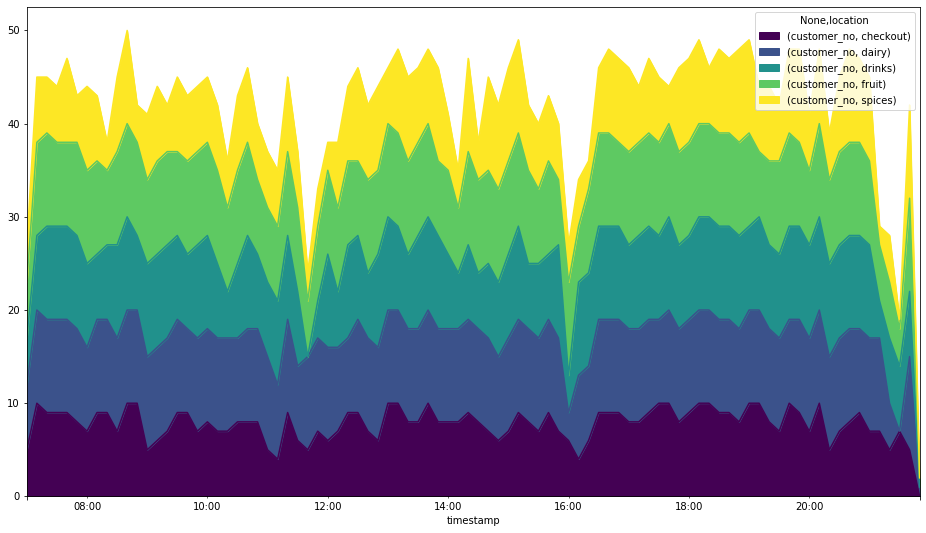

In [25]:
df3.groupby(['timestamp', 'location']).count().unstack(level=1).resample('10T').count().plot.area(cmap='viridis')
plt.gcf().set_size_inches(16, 9)

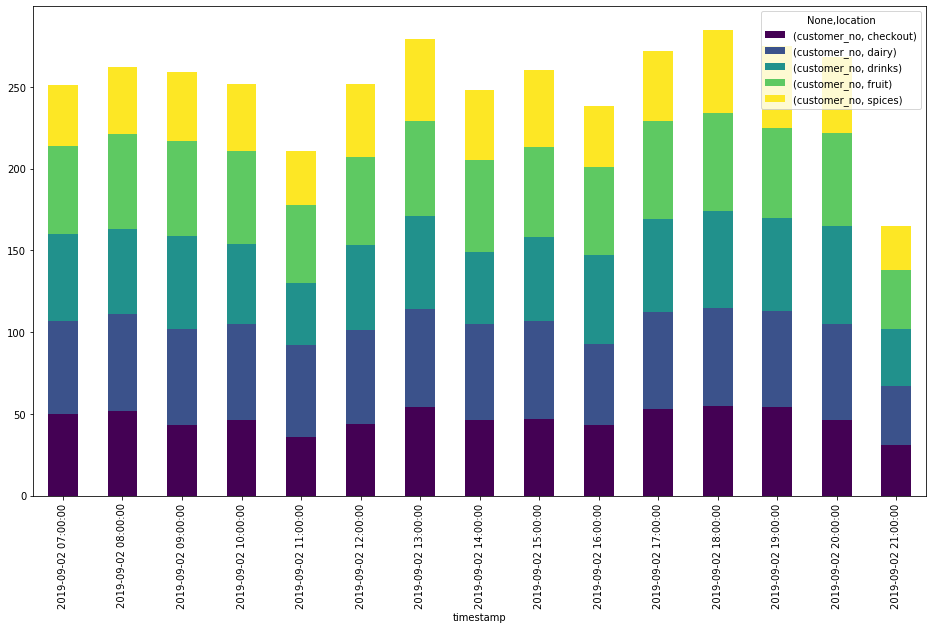

In [26]:
df3.groupby(['timestamp', 'location']).count().unstack(level=1).resample('H').count().plot.bar(stacked=True, cmap='viridis')
plt.gcf().set_size_inches(16, 9)

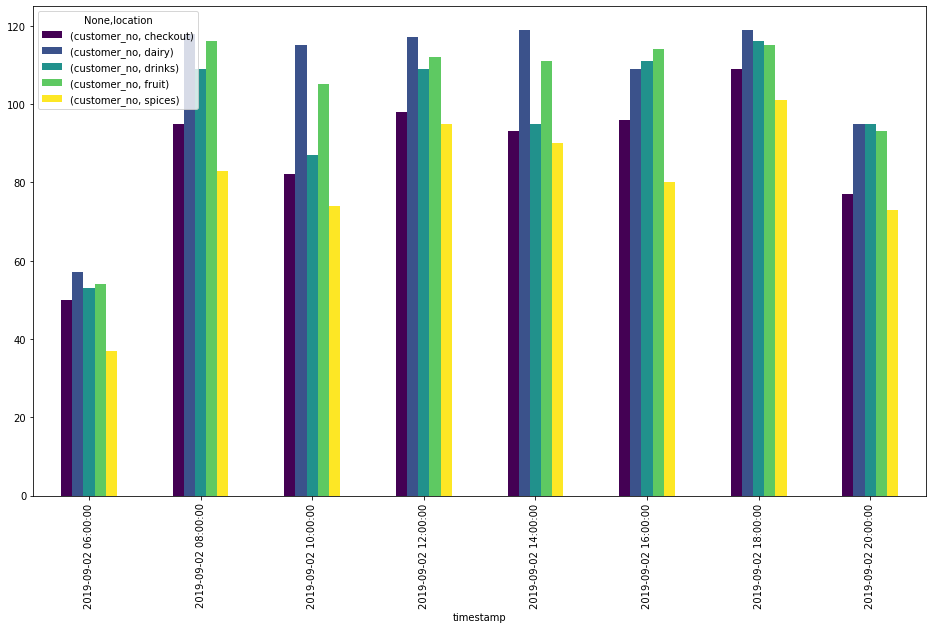

In [27]:
df3.groupby(['timestamp', 'location']).count().unstack(level=1).resample('2H').count().plot.bar(cmap='viridis')
plt.gcf().set_size_inches(16, 9)

#### Display the number of customers at checkout over time

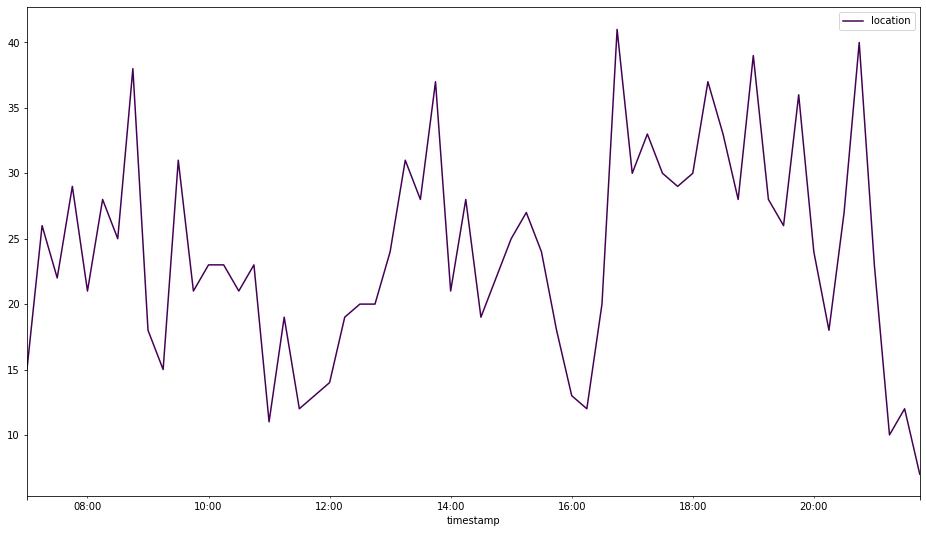

In [44]:
df[df['location'] == 'checkout'].resample('15T').count().plot(y='location', cmap='viridis')
plt.gcf().set_size_inches(16, 9)

#### Calculate the time each customer spent in the market

#### Calculate the total number of customers present in the supermarket over time.

#### Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).